## POS tagging using modified Viterbi

### Objective

- Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
- Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

### Data Preparation

####  Importing the required libraries for EDA

In [1]:
#Importing libraries
from pprint import pprint
import nltk
import numpy as np
import pandas as pd
import random
import time

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [3]:
# read the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
# Get the top some data to understand it
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [5]:
# Split the data into test and train sets
random.seed(1000)
train_set, test_set = train_test_split(nltk_data, test_size=0.05)

print("Size of Train Set: {0}".format(len(train_set)))
print("Size of Test Set: {0}".format(len(test_set)))

Size of Train Set: 3718
Size of Test Set: 196


In [6]:
print(train_set[:15])

[[('Says', 'VERB'), ('*ICH*-1', 'X'), ('Mr.', 'NOUN'), ('Baldwin', 'NOUN'), (',', '.'), ('``', '.'), ('We', 'PRON'), ('recognize', 'VERB'), ('that', 'ADP'), ('we', 'PRON'), ('may', 'VERB'), ('no', 'ADV'), ('longer', 'ADV'), ('have', 'VERB'), ('as', 'ADV'), ('high', 'ADJ'), ('a', 'DET'), ('priority', 'NOUN'), ('in', 'ADP'), ('church', 'NOUN'), ('life', 'NOUN'), ('and', 'CONJ'), ('experience', 'NOUN'), ('.', '.'), ("''", '.')], [('Her', 'PRON'), ('story', 'NOUN'), ('is', 'VERB'), ('partly', 'ADV'), ('one', 'NOUN'), ('of', 'ADP'), ('personal', 'ADJ'), ('downfall', 'NOUN'), ('.', '.')], [('The', 'DET'), ('SEC', 'NOUN'), ('documents', 'NOUN'), ('describe', 'VERB'), ('those', 'DET'), ('chips', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('are', 'VERB'), ('made', 'VERB'), ('*-22', 'X'), ('of', 'ADP'), ('gallium', 'NOUN'), ('arsenide', 'NOUN'), (',', '.'), ('as', 'ADP'), ('*-2', 'X'), ('being', 'VERB'), ('so', 'ADV'), ('fragile', 'ADJ'), ('and', 'CONJ'), ('minute', 'ADJ'), ('0', 'X'

In [7]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95611

In [8]:
train_tagged_words[:10]

[('Says', 'VERB'),
 ('*ICH*-1', 'X'),
 ('Mr.', 'NOUN'),
 ('Baldwin', 'NOUN'),
 (',', '.'),
 ('``', '.'),
 ('We', 'PRON'),
 ('recognize', 'VERB'),
 ('that', 'ADP'),
 ('we', 'PRON')]

In [9]:
# Get the tokens 
train_tokens = [pair[0] for pair in train_tagged_words]
train_tokens[:20]

['Says',
 '*ICH*-1',
 'Mr.',
 'Baldwin',
 ',',
 '``',
 'We',
 'recognize',
 'that',
 'we',
 'may',
 'no',
 'longer',
 'have',
 'as',
 'high',
 'a',
 'priority',
 'in',
 'church']

In [10]:
# POS tags for the tokens in the train set -
train_data_pos_tags = [pair[1] for pair in train_tagged_words]
train_data_pos_tags[:15]

['VERB',
 'X',
 'NOUN',
 'NOUN',
 '.',
 '.',
 'PRON',
 'VERB',
 'ADP',
 'PRON',
 'VERB',
 'ADV',
 'ADV',
 'VERB',
 'ADV']

In [11]:
# building the train vocabulary to a set
train_vocabulary_set = set(train_tokens)
print("Vocabulary length:{0}".format(len(train_vocabulary_set)))

Vocabulary length:12091


In [12]:
# building the POS tags to a set
train_pos_tag_set = set(train_data_pos_tags)
print("Tags length: {0}".format(len(train_pos_tag_set)))

Tags length: 12


In [13]:
print("Tags present")
train_pos_tag_set

Tags present


{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

### Build the Vanilla Viterbi based POS tagger

### Emission and Transition Probabilities

In [14]:
# computing P(word/tag) and storing in Tags x Vocabulary matrix
train_tags_length = len(train_pos_tag_set)
vocab_length = len(train_vocabulary_set)
word_given_tag = np.zeros((train_tags_length, vocab_length))

In [15]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag=train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1] == tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [16]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag=train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t == t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index] == t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [17]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((train_tags_length, train_tags_length), dtype='float32')
for i, t1 in enumerate(list(train_pos_tag_set)):
    for j, t2 in enumerate(list(train_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0] / t2_given_t1(t2, t1)[1]

In [18]:
tags_matrix

array([[6.56790137e-02, 1.67901237e-02, 6.56790137e-02, 5.10288076e-03,
        2.09053494e-02, 6.97777748e-01, 7.78600797e-02, 1.25102885e-02,
        6.58436213e-04, 2.15637852e-02, 1.06995888e-02, 4.77366243e-03],
       [1.16527393e-01, 4.64252545e-04, 3.52831930e-02, 1.18384399e-01,
        4.03899737e-02, 3.49117935e-01, 5.52460551e-02, 1.56917363e-01,
        5.89600727e-02, 8.35654605e-03, 5.10677788e-03, 5.52460551e-02],
       [4.42152470e-02, 5.85650206e-02, 9.33632255e-02, 1.73811659e-01,
        8.08071718e-02, 2.21434981e-01, 9.13004503e-02, 8.91479850e-02,
        6.57399073e-02, 2.65470855e-02, 2.42152461e-03, 5.25560528e-02],
       [2.04828009e-01, 4.82800242e-04, 1.78636089e-02, 5.43150259e-03,
        2.12432109e-02, 6.39951706e-01, 9.29390453e-03, 3.95896211e-02,
        3.37960175e-03, 4.50211242e-02, 1.20700061e-04, 1.27942069e-02],
       [3.30357142e-02, 1.33928573e-02, 1.16369046e-01, 3.27380956e-03,
        1.82738096e-01, 3.54464293e-01, 3.60119045e-02, 1.75

In [19]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(train_pos_tag_set), index=list(train_pos_tag_set))
tags_df

,ADJ,CONJ,.,DET,NUM,NOUN,ADP,VERB,PRON,X,PRT,ADV
ADJ,0.065679,0.016790,0.065679,0.005103,0.020905,0.697778,0.077860,0.012510,0.000658,0.021564,0.010700,0.004774
CONJ,0.116527,0.000464,0.035283,0.118384,0.040390,0.349118,0.055246,0.156917,0.058960,0.008357,0.005107,0.055246
.,0.044215,0.058565,0.093363,0.173812,0.080807,0.221435,0.091300,0.089148,0.065740,0.026547,0.002422,0.052556
DET,0.204828,0.000483,0.017864,0.005432,0.021243,0.639952,0.009294,0.039590,0.003380,0.045021,0.000121,0.012794
NUM,0.033036,0.013393,0.116369,0.003274,0.182738,0.354464,0.036012,0.017560,0.001190,0.211012,0.027976,0.002976
NOUN,0.012147,0.042349,0.240197,0.012949,0.009447,0.264563,0.176728,0.147292,0.004669,0.028743,0.043881,0.017034
ADP,0.106987,0.000853,0.039680,0.325867,0.062827,0.321493,0.017280,0.007680,0.067947,0.034667,0.001387,0.013333
VERB,0.065060,0.005597,0.035678,0.133618,0.023086,0.109988,0.091178,0.168442,0.035367,0.218733,0.031325,0.081928
PRON,0.074002,0.005424,0.040294,0.009299,0.007361,0.206122,0.021310,0.487408,0.006974,0.094924,0.012786,0.034095
X,0.016879,0.010510,0.164490,0.053662,0.002707,0.062739,0.144108,0.204618,0.055732,0.075000,0.183439,0.026115


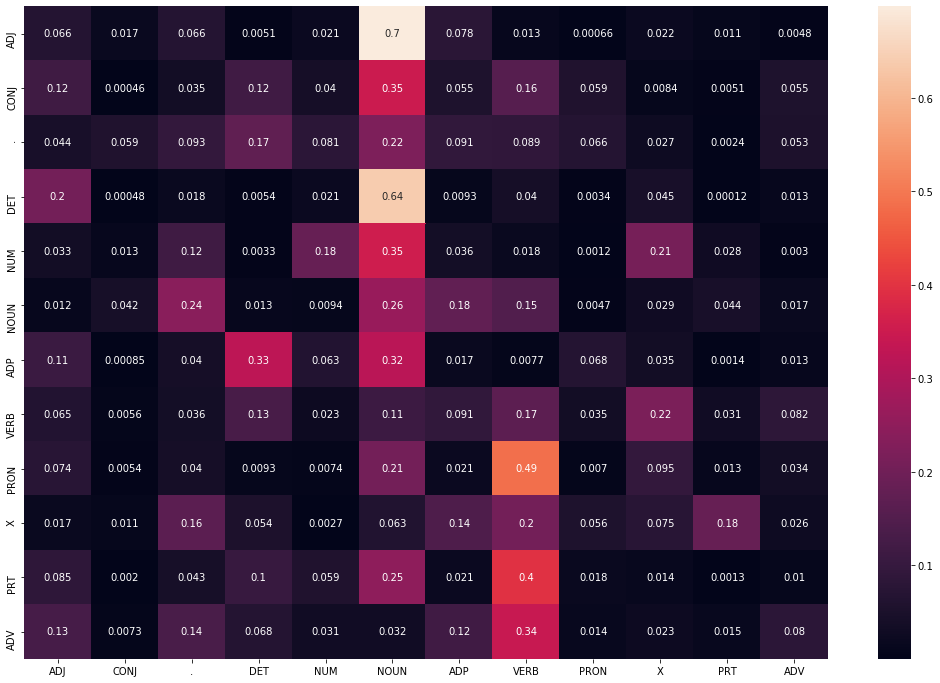

In [20]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df, annot=True)
plt.show()

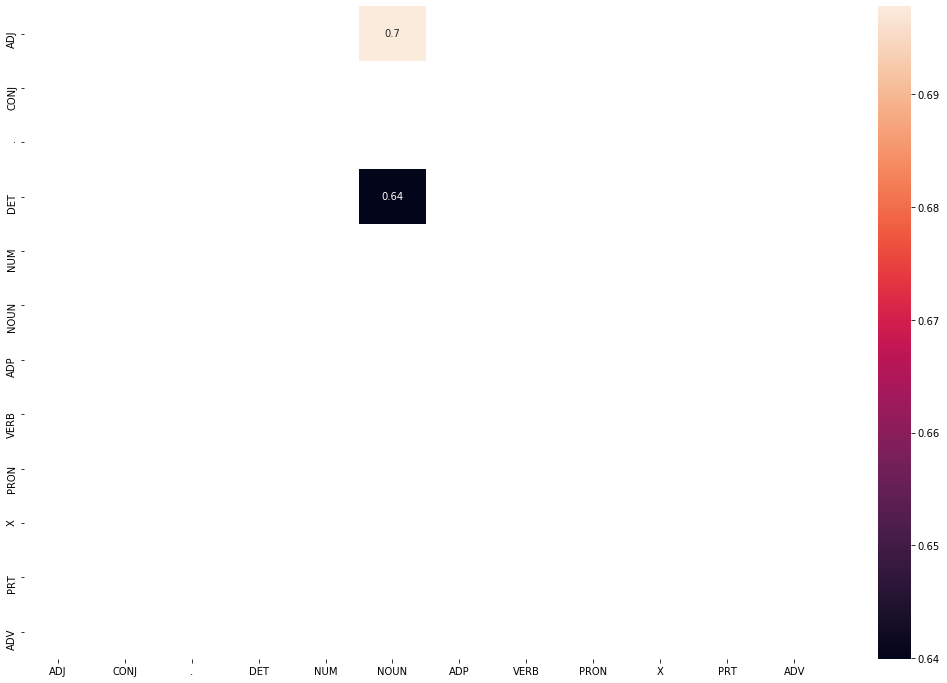

In [21]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent, annot=True)
plt.show()

In [22]:
# Vanilla Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [23]:
# Testing the vanilla viterbi algorithm with test sentences
random.seed(1000)

# get the list of tag words
test_run_base = [tup for sent in test_set for tup in sent]

# get the list of un-tagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [24]:
# Tag the test sentences and evaluate the time
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end - start

In [25]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  1988.165777206421
[('``', '.'), ('Feeding', 'NOUN'), ('Frenzy', 'NOUN'), ("''", '.'), ('does', 'VERB'), ('provide', 'VERB'), ('a', 'DET'), ('few', 'ADJ'), ('clues', 'NOUN'), ('.', '.'), ('But', 'CONJ'), ('Columbia', 'NOUN'), ("'s", 'PRT'), ('good', 'ADJ'), ('bank', 'NOUN'), ('would', 'VERB'), ('be', 'VERB'), ('a', 'DET'), ('regulated', 'VERB'), ('thrift', 'NOUN'), (',', '.'), ('while', 'ADP'), ('the', 'DET'), ('bad', 'ADJ'), ('bank', 'NOUN'), ('would', 'VERB'), ('be', 'VERB'), ('a', 'DET'), ('private', 'ADJ'), ('investment', 'NOUN'), ('company', 'NOUN'), (',', '.'), ('holding', 'VERB'), ('some', 'DET'), ('of', 'ADP'), ('Columbia', 'NOUN'), ("'s", 'PRT'), ('junk', 'NOUN'), ('bonds', 'NOUN'), (',', '.'), ('real', 'ADJ'), ('estate', 'NOUN'), ('and', 'CONJ'), ('equity', 'NOUN'), ('investments', 'NOUN'), ('.', '.'), ('The', 'DET'), ('Bush', 'NOUN'), ('administration', 'NOUN'), ('has', 'VERB'), ('threatened', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('veto', 'NOUN'), ('s

In [26]:
# Get the accuracy for the vanilla viterbi algorithm
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
viterbi_accuracy = len(check) / len(tagged_seq)

print("Accuracy of Vanilla Viterbi Algorithm is:", viterbi_accuracy)

Accuracy of Vanilla Viterbi Algorithm is: 0.9218163869693978


In [27]:
# Get the incorrect tag words
incorrect_tagged_cases = [[test_run_base[i-1], j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print("Length of incorrected tags: {0}".format(len(incorrect_tagged_cases)))
incorrect_tagged_cases

Length of incorrected tags: 396


[[('to', 'PRT'), (('veto', 'NOUN'), ('veto', 'VERB'))],
 [('veto', 'VERB'), (('such', 'ADJ'), ('such', 'DET'))],
 [('it', 'PRON'), (('views', 'NOUN'), ('views', 'VERB'))],
 [('undesirable', 'ADJ'), (('intrusion', 'ADJ'), ('intrusion', 'NOUN'))],
 [('the', 'DET'), (('300-113', 'ADJ'), ('300-113', 'NUM'))],
 [('the', 'DET'), (('potential', 'ADJ'), ('potential', 'NOUN'))],
 [('to', 'PRT'), (('override', 'ADJ'), ('override', 'VERB'))],
 [('to', 'PRT'), (('waive', 'ADJ'), ('waive', 'VERB'))],
 [('The', 'DET'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('of', 'ADP'), (('Delegates', 'ADJ'), ('Delegates', 'NOUN'))],
 [('1985', 'NUM'), (('condemning', 'ADJ'), ('condemning', 'VERB'))],
 [('IRS', 'NOUN'), (('reporting', 'VERB'), ('reporting', 'NOUN'))],
 [('The', 'DET'), (("'82", 'ADJ'), ("'82", 'NUM'))],
 [('the', 'DET'), (('Spanish', 'ADJ'), ('Spanish', 'NOUN'))],
 [('needed', 'VERB'), (('*-126', 'ADJ'), ('*-126', 'X'))],
 [('*-126', 'X'), (('following', 'NOUN'), ('following', 'VERB'))],


### Solve the problem of unknown words

#### Method 1

The Vanilla Viterbi Algorithm gives an accuracy of about 92%. The loss of 8% is because of the unknown words. It means that whenever the algorithm finds an unknowm word, it assign a tag arbitarily.

In the first method, if the word is not present,it's emission probability will be zero. So in the modified algorithm, if the algorithm encounters an unknowm word, we will skip the emission probability and consider or calculate only the tranisition probability.

In [30]:
# Get the Unknown words 
test_vocabulary_set = set([tag for tag in test_tagged_words])
unknown_words = list(test_vocabulary_set - train_vocabulary_set)
print("Length of Unknown words:", len(unknown_words))
print()
print("Unknown Words:", unknown_words)

Length of Unknown words: 317

Unknown Words: ['*-91', '*T*-98', 'Spanish', '963', 'Namibian', 'pair', 'college-bowl', 'herself', '*T*-140', 'Filling', 'single-A', 'leapt', 'unrestricted', 'intrusion', 'prospectively', 'pressman', 'forthcoming', 'headlined', 'impeding', 'Examiner', 'golden', '28.4', 'carillons', 'Certainly', 'more-advanced', 'punitive', 'skipped', 'Ariail', 'rollover', 'Mattress', 'Signet', 'Competes', 'hedging', 'Westport', 'precise', 'notified', 'assembly-line', 'R', 'stare', '12\\/32', 'jolts', 'sluggishness', 'gambling', 'protective', 'foreigners', '7.65', 'dubbed', 'involvement', 'popularly', 'bedding', 'Mo', 'crashes', 'omnipresent', 'mininum-wage', 'pulls', 'Shipments', 'Piscataway', 'striving', 'Krenz', '*T*-136', 'megabytes', 'sacrificing', '29.3', '176', 'soliciting', 'odds', 'merger-related', 'enjoy', 'referrals', 'Ketchum', 'prevailing', 'impudent', 'drums', 'sentimental', 'manipulators', 'Ind.', 'disputed', 'rebounding', 'employers', 'furious', '*-152', 'he

In [31]:
# Modified Viterbi Heuristic Algorithm
def Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag])) 
    for key, word in enumerate(words):
        #calculate the probability for the given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # Calcuate emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # Modification to the current viterbi algorithm             
            if word not in train_vocabulary_set:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [32]:
# Tag the test sentences
unknown_word_tagged_seq = Viterbi_for_Unknown_Words(test_tagged_words)


unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]
optimized_viterbi_accuracy = len(unknown_word_check) / len(unknown_word_tagged_seq)

print("Accuracy of Viterbi Algorithm with modification for unknown words: ", optimized_viterbi_accuracy)

Accuracy of Viterbi Algorithm with modification forunknown words:  0.9370187561697927


**Observations**
- It seems like the accuracy of the modified Viterbi algorithm for handling unknowm words has increased compared to the Vanilla Viterbi algorithm.

So we will try some rule based POS tagging to increase the accuracy further.

In [33]:
# Get incorrect tagged cases
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(unknown_word_tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('to', 'PRT'), (('veto', 'NOUN'), ('veto', 'VERB'))],
 [('veto', 'VERB'), (('such', 'ADJ'), ('such', 'DET'))],
 [('it', 'PRON'), (('views', 'NOUN'), ('views', 'VERB'))],
 [('an', 'DET'), (('undesirable', 'NOUN'), ('undesirable', 'ADJ'))],
 [('the', 'DET'), (('300-113', 'NOUN'), ('300-113', 'NUM'))],
 [('the', 'DET'), (('potential', 'ADJ'), ('potential', 'NOUN'))],
 [('its', 'PRON'), (('protective', 'VERB'), ('protective', 'ADJ'))],
 [('``', '.'), (('golden', 'NOUN'), ('golden', 'ADJ'))],
 [('The', 'DET'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('of', 'ADP'), (('Delegates', 'DET'), ('Delegates', 'NOUN'))],
 [('1985', 'NUM'), (('condemning', 'NOUN'), ('condemning', 'VERB'))],
 [('IRS', 'NOUN'), (('reporting', 'VERB'), ('reporting', 'NOUN'))],
 [('The', 'DET'), (("'82", 'NOUN'), ("'82", 'NUM'))],
 [('Spanish', 'NOUN'),
  (('Renaissance-style', 'NOUN'), ('Renaissance-style', 'ADJ'))],
 [('the', 'DET'), (('tumultuous', 'NOUN'), ('tumultuous', 'ADJ'))],
 [('tumultuous', 'ADJ'), ((

In [34]:
# Unigram Tagger
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_accuracy = unigram_tagger.evaluate(test_set)
print("Accuracy of Unigram Tagger: ", unigram_accuracy)

Accuracy of Unigram Tagger:  0.9050345508390918


In [35]:
# Rule based tagger 
patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'), # All alpha numerics
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'), # Possesive and Plural Nouns             
    (r'.*s$', 'NOUN'),      
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # All special characters
    (r'.*ould$', 'X'), # All modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # Special adjectives
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Verb which ends with ing and es
    (r'[0-9].?[,\/]?[0-9]*','NUM') # All Numbers 
]

In [36]:
# Rule based taggers
rule_tagger = nltk.RegexpTagger(patterns)

# unigram tagger and rule based taggers
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff=rule_tagger)

accuracy_custom_tagger = rule_based_unigram_tagger.evaluate(test_set)
print("Accuracy of Unigram Tagger with RegexpTagger: ", accuracy_custom_tagger)

Accuracy of Unigram Tagger with RegexpTagger:  0.9318854886475815


In [37]:
 #Bigram tagger
bigram_tagger = nltk.BigramTagger(train_set, backoff=rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("Accuracy of Bigram Tagger with rule based unigram_tagger: ", accuracy_bigram_tagger)

Accuracy of Bigram Tagger with rule based unigram_tagger:  0.9370187561697927


In [38]:
# trigram tagger
trigram_tagger = nltk.TrigramTagger(train_set, backoff=bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("Accuracy of Trigram Tagger with bigram_tagger: ", accuracy_trigram_tagger)

Accuracy of Trigram Tagger with bigram_tagger:  0.9366238894373149


### Method 2

We came to know from the above rule based taggers, the trigram tagger backed by a bigram tagger gives an accuracy of 94%. So we will use the Viterbi Algorithm to use the trigram tagger as a backoff to increase the accuracy in this new modified method. <br>
In this new method, we will use the trigram tagger in the Viterbi algorithm if it encounters an unknown word.

In [39]:
# A trigram tagger with another rule based tagger.
def trigram_tagger(word, train_set = train_set):   
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # word ending with ing or es
    (r'.*ly$', 'ADV'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),    
    (r'^[aA-zZ].*[0-9]+','NOUN'),  
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),            
    (r'.*s$', 'NOUN'),  
    (r'.*ers$', 'NOUN'),
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
    (r'^(0|([*|-|$].*))','X'), # All special characters
    (r'.*ould$', 'X'),
    # That/this/these/those: Demonstrative determiners
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), 
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)
    # trigram by regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff=regex_based_tagger)

    return trigram_regex_tagger.tag_sents([[(word)]])

In [42]:
def viterbi_with_trigram_tagger(words, train_bag=train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))

    for key, word in enumerate(words):
        if word not in train_vocabulary_set:
            # Get the tag based on the trigram tagger
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # calculate emission and transition probablities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [43]:
# Tag the test sentences
viterbi_trigram_seq = viterbi_with_trigram_tagger(test_tagged_words)


viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_seq, test_run_base) if i == j]
viterbi_trigram_accuracy = len(viterbi_trigram_word_check) / len(viterbi_trigram_seq)
print("Accuracy of the viterbi with trigram tagger:", viterbi_trigram_accuracy)

Accuracy of the viterbi with trigram tagger: 0.9565646594274433


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [46]:
acccuracy_data = [['Vanilla Viterbi', viterbi_accuracy * 100], 
                  ['Optimized Vanilla Viterbi', optimized_viterbi_accuracy * 100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger * 100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger * 100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy * 100]]

acccuracy_df = pd.DataFrame(acccuracy_data, columns = ['Algorithm', 'Accuracy'])
acccuracy_df.set_index('Algorithm', drop = True, inplace = True)
acccuracy_df

,Accuracy
Algorithm,
Vanilla Viterbi,92.181639
Optimized Vanilla Viterbi,93.701876
Bigram Tagger + Unigram_tagger,93.701876
Trigram Tagger + Bigram_tagger,93.662389
Viterbi + Trigram_tagger,95.656466


In [47]:
# Get the test sentences from the text file
sentence_test = open('Test_sentences.txt',mode='r').read().split("\n")

In [48]:
test_tokenized_sents = [word_tokenize(sent) for sent in sentence_test]
test_corpus_pos_tags = nltk.pos_tag_sents(test_tokenized_sents, tagset='universal')
test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [49]:
# Get the list of untagged words
test_tagged_words = [tup[0] for sent in test_corpus_pos_tags for tup in sent]

# tagged words
test_test_run_base = [tup for sent in test_corpus_pos_tags for tup in sent]
test_test_run_base

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADJ'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('se

#### 1. Calculate Vanilla Viterbi on sample test data

In [50]:
# tag the test sentences
test_tagged_seq = Viterbi(test_tagged_words)

test_check = [i for i, j in zip(test_tagged_seq, test_test_run_base) if i == j]
vanilla_viterbi_accuracy = len(test_check)/len(test_tagged_seq)
print("Accuracy of Vanilla Viterbi: ", vanilla_viterbi_accuracy)

Accuracy of Vanilla Viterbi:  0.7624309392265194


#### 2. Calculate VanillaViterbi for unknown words on sample test data

In [52]:
# tag the test sentences
test_unknown_word_tagged_seq = Viterbi_for_Unknown_Words(test_tagged_words)


test_unknown_word_check = [i for i, j in zip(test_unknown_word_tagged_seq, test_test_run_base) if i == j]
optimized_viterbi_accuracy = len(test_unknown_word_check)/len(test_unknown_word_tagged_seq)
print("Accuracy of Vanilla Viterbi for unknown words: ", optimized_viterbi_accuracy)


Accuracy of Vanilla Viterbi for unknown words:  0.861878453038674


#### 3. Calculate Viterbi with Trigram Tagger on sample test data

In [54]:
# tag the test sentences
test_viterbi_trigram_tagged_seq = viterbi_with_trigram_tagger(test_tagged_words)

test_viterbi_trigram_check = [i for i, j in zip(test_viterbi_trigram_tagged_seq, test_test_run_base) if i == j]
viterbi_trigram_accuracy = len(test_viterbi_trigram_check)/len(test_viterbi_trigram_tagged_seq)
print("Accuracy of the Viterbi with trigram tagger: ", viterbi_trigram_accuracy)

Accuracy of the Viterbi with trigram tagger:  0.9281767955801105


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [55]:
# Read all the sentences
sentence_test = open('Test_sentences.txt',mode='r').read().split("\n")

### Case 1

In [56]:
# Get a sentence from the sample sentences
test_sentence_1 = sentence_test[0]
test_sentence_1

'Android is a mobile operating system developed by Google.'

In [57]:
words_test_sentence_1 = nltk.word_tokenize(test_sentence_1)

# Vanilla_Viterbi
pos_vanilla_viterbi = Viterbi(words_test_sentence_1)
print("Tag by Vanilla_Viterbi -\n", pos_vanilla_viterbi)

# Viterbi with Trigram tagger
pos_viterbi_trigram = viterbi_with_trigram_tagger(words_test_sentence_1)
print("Tag by Viterbi with trigramtagger -\n", pos_viterbi_trigram)

Tag by Vanilla_Viterbi -
 [('Android', 'ADJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADJ'), ('.', '.')]
Tag by Viterbi with trigramtagger -
 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [59]:
# Create a df with the results from vanilla and modified one
cols = ['Vanilla_Tags', 'Vanilla_Trigram_Correction']
tags_df_1 = pd.DataFrame(columns=cols)
tags_df_1 = tags_df_1.fillna(0)
tags_df_1.Vanilla_Tags = [tup for tup in pos_vanilla_viterbi]
tags_df_1.Vanilla_Trigram_Correction = [tup for tup in pos_viterbi_trigram]

tags_df_1

,Vanilla_Tags,Vanilla_Trigram_Correction
0,"(Android, ADJ)","(Android, NOUN)"
1,"(is, VERB)","(is, VERB)"
2,"(a, DET)","(a, DET)"
3,"(mobile, ADJ)","(mobile, ADJ)"
4,"(operating, NOUN)","(operating, NOUN)"
5,"(system, NOUN)","(system, NOUN)"
6,"(developed, VERB)","(developed, VERB)"
7,"(by, ADP)","(by, ADP)"
8,"(Google, ADJ)","(Google, NOUN)"
9,"(., .)","(., .)"


**Observations**
- As we can see that, in the Vanilla Viterbi algorithm it considers the word, `Android` as `ADJ`. It got  corrected in the new modified Viterbi algorithm, and correctly represented as `NOUN`

### Case 2

In [60]:
# Get a sentence from the sample sentences
test_sentence_2 = sentence_test[5]
test_sentence_2

'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'

In [61]:
words_test_sentence_2 = nltk.word_tokenize(test_sentence_2)

# Vanilla_Viterbi
pos_vanilla_viterbi_2 = Viterbi(words_test_sentence_2)
print("Tag by Vanilla_Viterbi -\n", pos_vanilla_viterbi_2)

# Viterbi with Trigram tagger
pos_viterbi_trigram_2 = viterbi_with_trigram_tagger(words_test_sentence_2)
print("Tag by Viterbi with trigramtagger -\n", pos_viterbi_trigram_2)

Tag by Vanilla_Viterbi -
 [('The', 'DET'), ('2018', 'ADJ'), ('FIFA', 'ADJ'), ('World', 'NOUN'), ('Cup', 'ADJ'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'ADJ'), ('FIFA', 'ADJ'), ('World', 'NOUN'), ('Cup', 'ADJ'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'ADJ'), ('contested', 'ADJ'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]
Tag by Viterbi with trigramtagger -
 [('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [63]:
# Create a df with the results from vanilla and modified one
tags_df_2 = pd.DataFrame(columns = cols)
tags_df_2 = tags_df_2.fillna(0)
tags_df_2.Vanilla_Tags = [tup for tup in pos_vanilla_viterbi_2]
tags_df_2.Vanilla_Trigram_Correction = [tup for tup in pos_viterbi_trigram_2]

tags_df_2

,Vanilla_Tags,Vanilla_Trigram_Correction
0,"(The, DET)","(The, DET)"
1,"(2018, ADJ)","(2018, NUM)"
2,"(FIFA, ADJ)","(FIFA, NOUN)"
3,"(World, NOUN)","(World, NOUN)"
4,"(Cup, ADJ)","(Cup, NOUN)"
5,"(is, VERB)","(is, VERB)"
6,"(the, DET)","(the, DET)"
7,"(21st, ADJ)","(21st, NUM)"
8,"(FIFA, ADJ)","(FIFA, NOUN)"
9,"(World, NOUN)","(World, NOUN)"


**Observations**
- As we can see that some of the words got tagged incorrectly in Vanilla Viterbi algorithm, like
    - 2018 as ADJ
    - FIFA as ADJ
    - Cup as ADJ
    - 21st as ADJ
    - tournament as ADJ
    - contested as ADJ
- In the modified Viterbi algorithm, these words got correctly tagged as;
    - 2018 as NUM
    - FIFA as NOUN
    - Cup as NOUN
    - 21st as NUM
    - tournament as NOUN
    - contested as VERB

### Case 3

In [64]:
# Get a sentence from the sample sentences
test_sentence_3 = sentence_test[7]
test_sentence_3

'Show me the cheapest round trips from Dallas to Atlanta'

In [67]:
words_test_sentence_3 = nltk.word_tokenize(test_sentence_3)

# Vanilla_Viterbi
pos_vanilla_viterbi_3 = Viterbi(words_test_sentence_3)
print("Tag by Vanilla_Viterbi -\n", pos_vanilla_viterbi_3)

# Viterbi with Trigram tagger
pos_viterbi_trigram_3 = viterbi_with_trigram_tagger(words_test_sentence_3)
print("Tag by Viterbi with trigramtagger -\n", pos_viterbi_trigram_3)

Tag by Vanilla_Viterbi -
 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'ADJ'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]
Tag by Viterbi with trigramtagger -
 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'NOUN'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]


In [68]:
tags_df_3 = pd.DataFrame(columns = cols)
tags_df_3 = tags_df_3.fillna(0)
tags_df_3.Vanilla_Tags = [tup for tup in pos_vanilla_viterbi_3]
tags_df_3.Vanilla_Trigram_Correction = [tup for tup in pos_viterbi_trigram_3]

tags_df_3

,Vanilla_Tags,Vanilla_Trigram_Correction
0,"(Show, NOUN)","(Show, NOUN)"
1,"(me, PRON)","(me, PRON)"
2,"(the, DET)","(the, DET)"
3,"(cheapest, ADJ)","(cheapest, ADJ)"
4,"(round, NOUN)","(round, NOUN)"
5,"(trips, ADJ)","(trips, NOUN)"
6,"(from, ADP)","(from, ADP)"
7,"(Dallas, NOUN)","(Dallas, NOUN)"
8,"(to, PRT)","(to, PRT)"
9,"(Atlanta, NOUN)","(Atlanta, NOUN)"


**Observations**
- As we can see that, in the Vanilla Viterbi algorithm it considers the word, `trips` as `ADJ`. It got  corrected in the new modified Viterbi algorithm, and correctly represented as `NOUN`.

#### Compare all the test sentences with Vanilla Viterbi and the two modified methods Viterbi algorithm.

In [70]:
# Default Vanilla Viterbi
test_with_vanilla_viterbi = Viterbi(test_tagged_words)
print("Tagging sequence - Vanilla_Viterbi\n\n\n", test_with_vanilla_viterbi)
print('*' * 140)

# Method 1 - POS tags with Vanilla Viterbi for unknown words
test_unknown_words = Viterbi_for_Unknown_Words(test_tagged_words)
print("Tagging sequence - viterbi transition probability for unknown words\n\n\n", test_unknown_words)
print('*' * 140)

# Method 2 - POS tags with Viterbi with Trigram_tagger
test_viterbi_trigram = viterbi_with_trigram_tagger(test_tagged_words)
print("Tagging sequence - Viterbi with trigram_tagger\n\n\n", test_viterbi_trigram)

Tagging sequence - Vanilla_Viterbi


 [('Android', 'ADJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADJ'), ('.', '.'), ('Android', 'ADJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADJ'), ('worldwide', 'ADJ'), ('on', 'ADP'), ('smartphones', 'ADJ'), ('since', 'ADP'), ('2011', 'ADJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADJ'), ('.', '.'), ('Google', 'ADJ'), ('and', 'CONJ'), ('Twitter', 'ADJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADJ'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADJ'), ("'s", 'PRT'), ('firehose', 'ADJ'), ('.', '.'), ('Twitter', 'ADJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'A

In [72]:
# Compare the results of Vanilla Viterbi along with two modified version with the actual pos tags
cols1 = [
    'Actual_Tags',
    'Tags_From_vanilla_viterbi',
    'Tags_From_Vanilla_Viterbi_Unknown_Words',
    'Tags_From_Vanilla_Viterbi_Trigram_Tagger'
]

tags_comparison_df = pd.DataFrame(columns= cols1)
tags_comparison_df = tags_comparison_df.fillna(0)

tags_comparison_df.Actual_Tags = [tup for tup in test_test_run_base]
tags_comparison_df.Tags_From_vanilla_viterbi = [tup for tup in test_with_vanilla_viterbi]
tags_comparison_df.Tags_From_Vanilla_Viterbi_Unknown_Words = [tup for tup in test_unknown_words]
tags_comparison_df.Tags_From_Vanilla_Viterbi_Trigram_Tagger = [tup for tup in test_viterbi_trigram]
tags_comparison_df[tags_comparison_df.Tags_From_vanilla_viterbi != tags_comparison_df.Tags_From_Vanilla_Viterbi_Trigram_Tagger]

,Actual_Tags,Tags_From_vanilla_viterbi,Tags_From_Vanilla_Viterbi_Unknown_Words,Tags_From_Vanilla_Viterbi_Trigram_Tagger
0,"(Android, NOUN)","(Android, ADJ)","(Android, NOUN)","(Android, NOUN)"
8,"(Google, NOUN)","(Google, ADJ)","(Google, DET)","(Google, NOUN)"
10,"(Android, NOUN)","(Android, ADJ)","(Android, NOUN)","(Android, NOUN)"
15,"(OS, NOUN)","(OS, ADJ)","(OS, NOUN)","(OS, NOUN)"
16,"(worldwide, NOUN)","(worldwide, ADJ)","(worldwide, NOUN)","(worldwide, NOUN)"
18,"(smartphones, NOUN)","(smartphones, ADJ)","(smartphones, DET)","(smartphones, VERB)"
20,"(2011, NUM)","(2011, ADJ)","(2011, DET)","(2011, NUM)"
25,"(2013, NUM)","(2013, ADJ)","(2013, DET)","(2013, NUM)"
27,"(Google, NOUN)","(Google, ADJ)","(Google, NOUN)","(Google, NOUN)"
29,"(Twitter, NOUN)","(Twitter, ADJ)","(Twitter, NOUN)","(Twitter, NOUN)"


## Conclusion

- We can see that the Vanilla Viterbi algorithm incorrectly tagged most of the words, and most of them got corrected with the modified Viterbi Algorithm which is backed up by Trigram tagger
- We have used two methods to modify the Viterbi Algorithm
    - `Method 1`: If we encounter a unknown word, we then calculate only the transition probability and considered the emission probabilty as zero.
    - `Method 2`: We have used a trigram tagger to back up the Vanilla Viterbi Algorithm if it encounters an unknown word
- For `method 1`, we have got an accuracy of `93.6%`
- For `method 2`, we have got an accuracy of `95.5%`
- We have tested the Method 2 (Viterbi Algorithm backed up by a trigram tagger) on the sample sentences which was given, and it seems like it has tagged correctly compared to Vanilla Viterbi and Modified Viterbi algorithms.

***